# Tutorial
# Inference - A Single Star
After installing CMDfit, two commands will be readily accessible: 

 + cmdfit.fitsingle()
 + cmdfit.fitall()
 
**At the moment I do NOT recommend running cmdfit.fitall(); its run time is very long (I have not run it to completion myself yet) and is still in development. Right now it will run fast because I have added breaks to skip iteration in certain parts for testing purposes, but the output is arbitrary in this case.**

Running the following commands in the top level install directory after starting up Python...

    import cmdfit
    cmdfit.fitsingle()
    
will run the code, as demonstrated below in this notebook.

In [7]:
%matplotlib inline

import cmdfit
import emcee
import numpy as np
import pandas as pd
import seaborn as sns

# Example run
Right now the cmdfit.fitsingle() function returns an emcee sampler object. I am not planning on having this be the case in the final code though. I will be performing plotting, etc. of the sampler's findings in an automated way. Right now I have it this way just for testing, however, a user may currently exploit this to do their own operations on the returned sampler object.  

Below I will run the code. It produces a lot of text output currently, as I navigate through the data tables to pick out the proper data columns (the tables are collected from various sources and are not formatted in a standard way). After that, a plot is produced, showing the samplers over their 300 step run time.  

The sampler was run with ndim = 4, nwalkers = 10, nsteps = 300.

SELECT DESIRED DATA PATH:
(Reading from /home/seth/Documents/Classes/PHYS201/sectiontest/CMDfit/cmdfit/data.)
-----------------------------------------------
Select the desired directory from those found below:
0) Hyades
Enter the index of the desired directory (requesting type: int): 0
-----------------------------------------------
-----------------------------------------------
Select the desired file from those found below:
0) goldman_less_Hyades.txt
1) vanleeuwen_out.txt
Enter the index of the desired file (requesting type: int): 0
-----------------------------------------------
Select data columns from goldman_less_Hyades.txt
0) Seq
1) RAJ2000
2) DEJ2000
3) pmRA
4) pmDE
5) plx
6) rc
7) RV
8) Vpar
9) Vperp
10) Mass
11) Jmag
12) Hmag
13) Kmag
14) W1mag
15) W2mag
16) src
ENTER COLUMN INDEX OF DESIRED FILTER:  (requesting type: int): 11

ASSIGNING DATA...

Loading data from goldman_less_Hyades.txt...


Converting from AB magnitude system to Vega system...
Applying distance modulus co

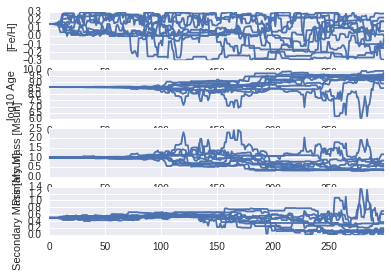

In [4]:
sampler = cmdfit.fitsingle()

The axes are a bit jumbled currently in the plot above, so I will fix that. However, the top axis is metallicity ([Fe/H]), below that is log10 age, and then primary initial mass, and finally primary secondary mass for the chosen star. Right now cmdfit.fitsingle() fits just to the first data point in the data table, but I plan on changing the code to allow the user to select a data point from the data table.

The data table is a collection of observations detailed in Goldman et al. 2013. The star that I have selected here has a 2MASS J band magnitude of 9.300, a 2MASS H band magnitude of 8.674, and a 2MASS K band magniude of 8.405. Errors did not exist for all stars in the data able, so I have applied a nominal +/- 0.1 dex uncertainty to the magnitude of the star in all bands. This is somewhat of a placeholder method for handling missing uncertainties, but +/- 0.1 dex is roughly
what is considered a typical uncertainty on a magnitude measurement (really it varies by band too, but I have not incorporated that here).

The burn-in time looks like it is around 100 steps, so I will cut these out. Having done that I will take a look at the relation between age and metallicity.
# Looking at [Fe/H] and log10 age for a single star

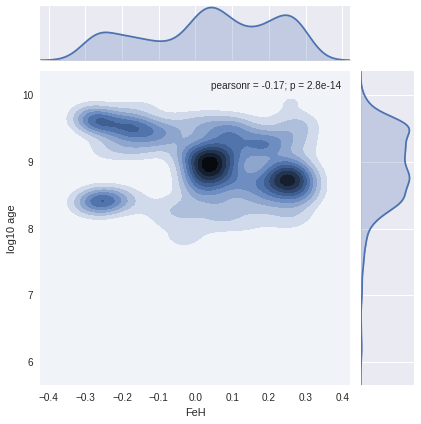

In [19]:
samples = sampler.chain[:,100:,:]

ndim = 4

# Reshaping into a 1D array with columns as FeH, log10 age, primary intial mass, and secondary initial mass:
traces = samples.reshape(-1, ndim).T

parameter_samples = pd.DataFrame({'FeH': traces[0], 'log10 age': traces[1], 
                                 'M1': traces[2], 'M2': traces[3]})

joint_kde = sns.jointplot(x='FeH',y='log10 age', data=parameter_samples, kind='kde')

The age vs metallicity plot above has two strong peaks near metallicity of 0 and ages of around 1 billion years.  

# MAP Values

In [20]:
q = parameter_samples.quantile([0.16, 0.50, 0.84], axis=0)
q

,FeH,M1,M2,log10 age
0.16,-0.191682,0.378200,0.145761,8.387016
0.50,0.054187,0.710902,0.481033,8.931095
0.84,0.239612,1.134417,0.607422,9.499492


In [21]:
print("[Fe/H] = {:.2f} + {:.2f} - {:.2f}".format(q['FeH'][0.50], 
                                                 q['FeH'][0.84] - q['FeH'][0.50], 
                                                 q['FeH'][0.50] - q['FeH'][0.16]))

print("log10 age = {:.2f} + {:.2f} - {:.2f}".format(q['log10 age'][0.50], 
                                                    q['log10 age'][0.84] - q['log10 age'][0.50], 
                                                    q['log10 age'][0.50] - q['log10 age'][0.16]))

print("M1 = {:.2f} + {:.2f} - {:.2f}".format(q['M1'][0.50], 
                                             q['M1'][0.84] - q['M1'][0.50], 
                                             q['M1'][0.50] - q['M1'][0.16]))

print("M2 = {:.2f} + {:.2f} - {:.2f}".format(q['M2'][0.50], 
                                             q['M2'][0.84] - q['M2'][0.50], 
                                             q['M2'][0.50] - q['M2'][0.16]))

[Fe/H] = 0.05 + 0.19 - 0.25
log10 age = 8.93 + 0.57 - 0.54
M1 = 0.71 + 0.42 - 0.33
M2 = 0.48 + 0.13 - 0.34


The sampler seems to have found that this star looks like a roughly 800 million year old star coming from a cluster with a metallicity of around 0.05 (super-solar), and with a primary mass of 0.71 Msun. The sampler also found that this star may have a secondary member in its system, i.e. a 0.48 Msun star.

Drawing too many conclusions about a single star in this way may be misguided though. At least the sampling seems to show that the star is maybe from a cluster around 800 Myr, with a metallicity of 0.5 (600 Myr is the expected age of the Hyades, without rotation; its expected metallicity is ~0.14 or so). It will be good to see what the full sampling looks like, however I may need to implement a faster sampling method in order to achieve that in a reasonable time it seems like. Futhermore, I have used fake uncertainties on this star's magnitude measurements, which likely also has an effect on determining the fit.

As is, this code is able to fit single stars via cmdfit.fitsingle(). I will continue to develop cmdfit.fitall() while making general improvements to the code.